# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [75]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [76]:
asl.df.ix[98,1]  # look at the data available for an individual fram

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [77]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [78]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [79]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly'] 
#show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,23][v] for v in features_ground]

[-38, 27, -13, 125]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [81]:
training = asl.build_training(features_ground)
print(len(training.words))
print("Training words: {}".format(training.words))

112
Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'G

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [82]:
training.get_word_Xlengths('POSS')

(array([[-39,  12, -19, 126],
        [-39,  12, -19, 126],
        [-32,  12, -19, 126],
        [-29,  15, -19, 126],
        [-29,  15, -19, 126],
        [-33,   6, -19, 126],
        [-39,   1,  -9, 119],
        [-41,  -5,  -7, 121],
        [-41,  -5,  -2, 114],
        [-45,  -7,  -4, 108],
        [-46,   0,  -2,  99],
        [-44,   3,   5,  89],
        [-39,  10,  10,  79],
        [-33,  16,  18,  67],
        [-17,  34,  11, 145],
        [-20,  31,  11, 145],
        [-23,  32,  11, 145],
        [-25,  32,  11, 145],
        [-34,  33,  11, 145],
        [-42,  28,  11, 145],
        [-49,  32,  11, 145],
        [-57,  32,  11, 145],
        [-64,  35,   9, 143],
        [ -8,  57, -12, 119],
        [-21,  47, -12, 119],
        [-37,  42, -14, 123],
        [-49,  36, -14, 123],
        [-53,  31, -14, 123],
        [-52,  33, -13, 125],
        [-47,  30, -13, 125],
        [-13,  27, -17, 124],
        [-13,  27, -17, 124],
        [-21,  26, -17, 124],
        [-

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [83]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [84]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  right-x-mean  
video frame                                                                 
98    0          113        9      119      -12   164.661438    151.017865  
      1          113        9      119      -12   164.661438    151.017865  
      2          113        9      119      -12   164.661438    151.017865  
      3          113        9      119      -12   164.661438    151.017865  
      4          113        9      119      -12   164.661438    151.017865

##### Try it!

In [85]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
df_std
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean,right-x-mean
speaker,,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [90]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

asl.df['norm-rx']= (asl.df['right-x'] - asl.df['speaker'].map(df_means['right-x']))/asl.df['speaker'].map(df_std['right-x'])
asl.df['norm-ry']= (asl.df['right-y'] - asl.df['speaker'].map(df_means['right-y']))/asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-lx']= (asl.df['left-x'] - asl.df['speaker'].map(df_means['left-x']))/asl.df['speaker'].map(df_std['left-x'])
asl.df['norm-ly']= (asl.df['left-y'] - asl.df['speaker'].map(df_means['left-y']))/asl.df['speaker'].map(df_std['left-y'])
df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,...,norm-lx,norm-ly,polar-rr,polar-lr,polar-rtheta,polar-ltheta,delta-rx,delta-ry,delta-lx,delta-ly
speaker,,,,,,,,,,,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,...,1.0,1.0,49.130795,34.261750,0.383495,0.162199,4.164496,9.429594,4.594018,6.381695
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,...,1.0,1.0,30.654063,25.133829,0.397837,0.219121,3.865013,6.606397,4.905386,5.031490
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,...,1.0,1.0,35.581422,27.234249,0.472623,0.181267,3.360151,6.713516,3.644353,5.011672


In [91]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

def radius(x,y):
    return np.sqrt(x**2 + y**2)

def arctan_angle(x,y):
    return np.arctan2(x,y)

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

asl.df['polar-rr'] = radius(asl.df['grnd-rx'],asl.df['grnd-ry'] )
asl.df['polar-lr'] = radius(asl.df['grnd-lx'],asl.df['grnd-ly'] )

asl.df['polar-rtheta'] = arctan_angle(asl.df['grnd-rx'],asl.df['grnd-ry'] )
asl.df['polar-ltheta'] = arctan_angle(asl.df['grnd-lx'],asl.df['grnd-ly'] )
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly        ...          polar-rtheta  \
video frame                                   ...                         
98    0          113        9      119        ...              0.079478   
      1          113        9      119        ...              0.079478   
      2          113        9      119        ...              0.079478   
      3          113        9      119        ...              0.079478   
      4          113        9      119        ...              0.079478   

             polar-ltheta  delta-rx  delta-ry  delta-lx  delta-ly  \
video frame                                                         
98    0         -0.100501       0.0       0.0       0.0       0.0   
      1         -0.100501       0.0       0.0       0.0       0.0   
      2         -0.100501       0.0       0.0       0.0       0.0   
      3         -0.100501       0.0       0.0       0.0       0.0   
      4         -0.100501       0.0       0.0       0.0       0.0   

             polar-norm-rr  polar-norm-lr  polar-norm-rtheta  \
video frame                                                    
98    0           1.573439       0.542499           0.959419   
      1           1.573439       0.542499           0.959419   
      2           1.573439       0.542499           0.959419   
      3           1.573439       0.542499           0.959419   
      4           1.573439       0.542499           0.959419   

             polar-norm-ltheta  
video frame                     
98    0              -0.735219  
      1              -0.735219  
      2              -0.735219  
      3              -0.735219  
      4              -0.735219  

[5 rows x 29 columns]

In [93]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(value=0, axis=0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(value=0, axis=0)

asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(value=0, axis=0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(value=0, axis=0)


asl.df.tail(6)

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
125   51        148     181      169      147     162      60  woman-1   
      52        148     181      171      156     162      60  woman-1   
      53        148     181      172      165     162      60  woman-1   
      54        148     181      175      173     162      60  woman-1   
      55        148     181      175      173     162      60  woman-1   
      56        148     181      175      173     162      60  woman-1   

             grnd-ry  grnd-rx  grnd-ly        ...          polar-rtheta  \
video frame                                   ...                         
125   51          87        7      121        ...              0.080287   
      52          96        9      121        ...              0.093477   
      53         105       10      121        ...              0.094952   
      54         113       13      121        ...              0.114541   
      55         113       13      121        ...              0.114541   
      56         113       13      121        ...              0.114541   

             polar-ltheta  delta-rx  delta-ry  delta-lx  delta-ly  \
video frame                                                         
125   51         -0.11519       4.0      10.0      -4.0       4.0   
      52         -0.11519       2.0       9.0       0.0       0.0   
      53         -0.11519       1.0       9.0       0.0       0.0   
      54         -0.11519       3.0       8.0       0.0       0.0   
      55         -0.11519       0.0       0.0       0.0       0.0   
      56         -0.11519       0.0       0.0       0.0       0.0   

             polar-norm-rr  polar-norm-lr  polar-norm-rtheta  \
video frame                                                    
125   51          0.722763       0.630178           0.961451   
      52          1.020923       0.630178           0.994605   
      53          1.316288       0.630178           0.998313   
      54          1.586080       0.630178           1.047551   
      55          1.586080       0.630178           1.047551   
      56          1.586080       0.630178           1.047551   

             polar-norm-ltheta  
video frame                     
125   51             -0.802258  
      52             -0.802258  
      53             -0.802258  
      54             -0.802258  
      55             -0.802258  
      56             -0.802258  

[6 rows x 29 columns]

In [94]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# TODO define a list named 'features_custom' for building the training set

# Normalize the polar co-ordinates

df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

features_polar_norm = ['polar-norm-rr', 'polar-norm-rtheta', 'polar-norm-lr', 'polar-norm-ltheta']

asl.df['polar-norm-rr']= (asl.df['polar-rr'] - asl.df['speaker'].map(df_means['polar-rr']))/asl.df['speaker'].map(df_std['polar-rr'])
asl.df['polar-norm-lr']= (asl.df['polar-lr'] - asl.df['speaker'].map(df_means['polar-lr']))/asl.df['speaker'].map(df_std['polar-lr'])

asl.df['polar-norm-rtheta']= (asl.df['polar-rtheta'] - asl.df['speaker'].map(df_means['polar-rtheta']))/asl.df['speaker'].map(df_std['polar-rtheta'])
asl.df['polar-norm-ltheta']= (asl.df['polar-ltheta'] - asl.df['speaker'].map(df_means['polar-ltheta']))/asl.df['speaker'].map(df_std['polar-ltheta'])

asl.df.head()



left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly        ...          polar-rtheta  \
video frame                                   ...                         
98    0          113        9      119        ...              0.079478   
      1          113        9      119        ...              0.079478   
      2          113        9      119        ...              0.079478   
      3          113        9      119        ...              0.079478   
      4          113        9      119        ...              0.079478   

             polar-ltheta  delta-rx  delta-ry  delta-lx  delta-ly  \
video frame                                                         
98    0         -0.100501       0.0       0.0       0.0       0.0   
      1         -0.100501       0.0       0.0       0.0       0.0   
      2         -0.100501       0.0       0.0       0.0       0.0   
      3         -0.100501       0.0       0.0       0.0       0.0   
      4         -0.100501       0.0       0.0       0.0       0.0   

             polar-norm-rr  polar-norm-lr  polar-norm-rtheta  \
video frame                                                    
98    0           1.573439       0.542499           0.959419   
      1           1.573439       0.542499           0.959419   
      2           1.573439       0.542499           0.959419   
      3           1.573439       0.542499           0.959419   
      4           1.573439       0.542499           0.959419   

             polar-norm-ltheta  
video frame                     
98    0              -0.735219  
      1              -0.735219  
      2              -0.735219  
      3              -0.735219  
      4              -0.735219  

[5 rows x 29 columns]

In [187]:
# Min Max Normalization
# Min-max normalization performs a linear alteration on the original data. 
# Here the features are normalized to fall within the range [-1,1]

df_min = asl.df.groupby('speaker').min()
df_max = asl.df.groupby('speaker').max()

features_min_max = ['min_max-rx', 'min_max-ry', 'min_max-lx', 'min_max-ly']
asl.df['min_max-rx']= (2*asl.df['right-x'] - asl.df['speaker'].map(df_min['right-x']) - asl.df['speaker'].map(df_max['right-x']))/ (asl.df['speaker'].map(df_max['right-x']) - asl.df['speaker'].map(df_min['right-x']))
asl.df['min_max-ry']= (2*asl.df['right-y'] - asl.df['speaker'].map(df_min['right-y']) - asl.df['speaker'].map(df_max['right-y']))/ (asl.df['speaker'].map(df_max['right-y']) - asl.df['speaker'].map(df_min['right-y']))

asl.df['min_max-lx']= (2*asl.df['left-x'] - asl.df['speaker'].map(df_min['left-x']) - asl.df['speaker'].map(df_max['left-x']))/ (asl.df['speaker'].map(df_max['left-x']) - asl.df['speaker'].map(df_min['left-x']))
asl.df['min_max-ly']= (2*asl.df['left-y'] - asl.df['speaker'].map(df_min['left-y']) - asl.df['speaker'].map(df_max['left-y']))/ (asl.df['speaker'].map(df_max['left-y']) - asl.df['speaker'].map(df_min['left-y']))

asl.df.tail()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
125   52        148     181      171      156     162      60  woman-1   
      53        148     181      172      165     162      60  woman-1   
      54        148     181      175      173     162      60  woman-1   
      55        148     181      175      173     162      60  woman-1   
      56        148     181      175      173     162      60  woman-1   

             grnd-ry  grnd-rx  grnd-ly         ...           \
video frame                                    ...            
125   52          96        9      121         ...            
      53         105       10      121         ...            
      54         113       13      121         ...            
      55         113       13      121         ...            
      56         113       13      121         ...            

             polar-norm-rtheta  polar-norm-ltheta  min_max-rx  min_max-ry  \
video frame                                                                 
125   52              0.994605          -0.802258    0.339130    0.676056   
      53              0.998313          -0.802258    0.356522    0.802817   
      54              1.047551          -0.802258    0.408696    0.915493   
      55              1.047551          -0.802258    0.408696    0.915493   
      56              1.047551          -0.802258    0.408696    0.915493   

             min_max-lx  min_max-ly  polar-minmax-rr  polar-minmax-rtheta  \
video frame                                                                 
125   52        -0.8125    0.813084         0.503379             0.430388   
      53        -0.8125    0.813084         0.655722             0.431202   
      54        -0.8125    0.813084         0.794875             0.442014   
      55        -0.8125    0.813084         0.794875             0.442014   
      56        -0.8125    0.813084         0.794875             0.442014   

             polar-minmax-lr  polar-minmax-ltheta  
video frame                                        
125   52            0.670843            -0.876178  
      53            0.670843            -0.876178  
      54            0.670843            -0.876178  
      55            0.670843            -0.876178  
      56            0.670843            -0.876178  

[5 rows x 37 columns]

In [188]:
features_polar_min_max= ['polar-minmax-rr', 'polar-minmax-rtheta', 'polar-minmax-lr', 'polar-minmax-ltheta']

asl.df['polar-minmax-rr']= (2*asl.df['polar-rr'] - asl.df['speaker'].map(df_min['polar-rr']) - asl.df['speaker'].map(df_max['polar-rr']))/ (asl.df['speaker'].map(df_max['polar-rr']) - asl.df['speaker'].map(df_min['polar-rr']))
asl.df['polar-minmax-rtheta']= (2*asl.df['polar-rtheta'] - asl.df['speaker'].map(df_min['polar-rtheta']) - asl.df['speaker'].map(df_max['polar-rtheta']))/ (asl.df['speaker'].map(df_max['polar-rtheta']) - asl.df['speaker'].map(df_min['polar-rtheta']))

asl.df['polar-minmax-lr']= (2*asl.df['polar-lr'] - asl.df['speaker'].map(df_min['polar-lr']) - asl.df['speaker'].map(df_max['polar-lr']))/ (asl.df['speaker'].map(df_max['polar-lr']) - asl.df['speaker'].map(df_min['polar-lr']))
asl.df['polar-minmax-ltheta']= (2*asl.df['polar-ltheta'] - asl.df['speaker'].map(df_min['polar-ltheta']) - asl.df['speaker'].map(df_max['polar-ltheta']))/ (asl.df['speaker'].map(df_max['polar-ltheta']) - asl.df['speaker'].map(df_min['polar-ltheta']))

asl.df.tail()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
125   52        148     181      171      156     162      60  woman-1   
      53        148     181      172      165     162      60  woman-1   
      54        148     181      175      173     162      60  woman-1   
      55        148     181      175      173     162      60  woman-1   
      56        148     181      175      173     162      60  woman-1   

             grnd-ry  grnd-rx  grnd-ly         ...           \
video frame                                    ...            
125   52          96        9      121         ...            
      53         105       10      121         ...            
      54         113       13      121         ...            
      55         113       13      121         ...            
      56         113       13      121         ...            

             polar-norm-rtheta  polar-norm-ltheta  min_max-rx  min_max-ry  \
video frame                                                                 
125   52              0.994605          -0.802258    0.339130    0.676056   
      53              0.998313          -0.802258    0.356522    0.802817   
      54              1.047551          -0.802258    0.408696    0.915493   
      55              1.047551          -0.802258    0.408696    0.915493   
      56              1.047551          -0.802258    0.408696    0.915493   

             min_max-lx  min_max-ly  polar-minmax-rr  polar-minmax-rtheta  \
video frame                                                                 
125   52        -0.8125    0.813084         0.503379             0.430388   
      53        -0.8125    0.813084         0.655722             0.431202   
      54        -0.8125    0.813084         0.794875             0.442014   
      55        -0.8125    0.813084         0.794875             0.442014   
      56        -0.8125    0.813084         0.794875             0.442014   

             polar-minmax-lr  polar-minmax-ltheta  
video frame                                        
125   52            0.670843            -0.876178  
      53            0.670843            -0.876178  
      54            0.670843            -0.876178  
      55            0.670843            -0.876178  
      56            0.670843            -0.876178  

[5 rows x 37 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** 

3 Customer Features created:
- Min-Max Feature Scaling on Right-x,Right-y, Left-x and Left-y variables to linearly transform the data into [-1,1] range interval.
- Normalize the Polar Co-ordinates by subtracting the mean and divide by the standard deviation.
- Min-Max Feature Scaling on Polar co-ordinates to linearly transform the data into [-1,1] range interval.
    

The custom feature that was chosen was to feature scale Right-x,Right-y,Left-x and Left-y co-ordinates. The selection is backed up/supported by the Low Word Error Rate (you'll observe in the below sections) when recognizing the sentences on the test set.

Another advantage of Scaling the co-ordinates is it will condense the values to fit into standard interval of [-1,1] resulting in easier interpretation of the data.
It also helps Expectation-Maximization algorithm to converge faster. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [195]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [203]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'POSS'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for POSS is 3
logL = -1217.495696182737


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [204]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for POSS is 3
hidden state #0
mean =  [ -39.03363527   24.55709619  -15.07844058  123.87817916]
variance =  [ 203.20897319  132.05433256    8.79739444    5.12875569]

hidden state #1
mean =  [ -42.21052632   45.57894737   27.47368421  180.        ]
variance =  [ 103.00883657   12.03376731   12.67088643   97.68473684]

hidden state #2
mean =  [ -38.14992982   20.08266464   10.51300336  124.67846517]
variance =  [ 122.78117094  190.41561891   64.90919387  580.85258797]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [221]:
my_testword = 'POSS'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for POSS is 3
hidden state #0
mean =  [ -39.03363527   24.55709619  -15.07844058  123.87817916]
variance =  [ 203.20897319  132.05433256    8.79739444    5.12875569]

hidden state #1
mean =  [ -42.21052632   45.57894737   27.47368421  180.        ]
variance =  [ 103.00883657   12.03376731   12.67088643   97.68473684]

hidden state #2
mean =  [ -38.14992982   20.08266464   10.51300336  124.67846517]
variance =  [ 122.78117094  190.41561891   64.90919387  580.85258797]

logL = -1217.495696182737


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [217]:
%matplotlib inline

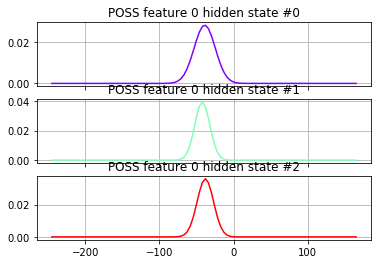

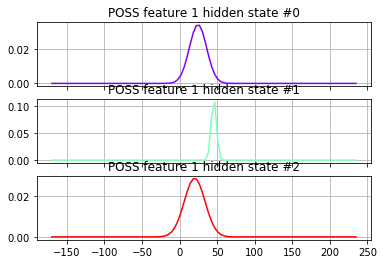

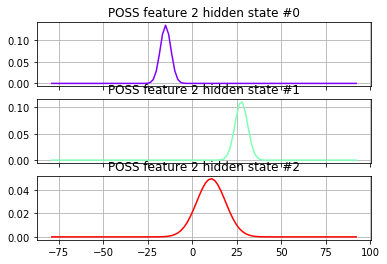

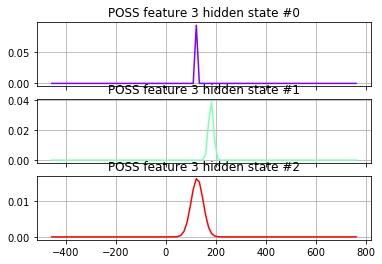

In [222]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [223]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_norm)  # Experiment here with different feature sets defined in part 1
word = 'JOHN' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for JOHN is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [105]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'POSS' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
X, lengths = training.get_word_Xlengths(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds    

Train fold indices:[ 4  5  6  7  8  9 10] Test fold indices:[0 1 2 3]
Train fold indices:[ 0  1  2  3  8  9 10] Test fold indices:[4 5 6 7]
Train fold indices:[0 1 2 3 4 5 6 7] Test fold indices:[ 8  9 10]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [106]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [183]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_min_max)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.21055142089971923 seconds
Training complete for BOOK with 11 states with time 2.8270225110936735 seconds
Training complete for VEGETABLE with 9 states with time 1.0704846872940834 seconds
Training complete for FUTURE with 3 states with time 2.7091735712419904 seconds
Training complete for JOHN with 15 states with time 23.00431954461601 seconds


In [182]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_min_max)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.1904278666479513 seconds
Training complete for BOOK with 2 states with time 1.3838957913358172 seconds
Training complete for VEGETABLE with 2 states with time 0.5111456872255076 seconds
Training complete for FUTURE with 2 states with time 1.455618320571375 seconds
Training complete for JOHN with 2 states with time 15.752199884009315 seconds


In [224]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_polar_min_max)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.3817977195067215 seconds
Training complete for BOOK with 14 states with time 2.849746427629725 seconds
Training complete for VEGETABLE with 4 states with time 1.7698809678913676 seconds
Training complete for FUTURE with 15 states with time 2.422142169150902 seconds
Training complete for JOHN with 15 states with time 11.400838002384262 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** 

**K-Fold cross validation** provides a proxy method of finding the best model to use on "unseen data". The  data is divided into k randomly assigned subsets and everytime one of the k-subsets is held out as the testing set. Training is done on remaining k-1 subsets and performance is measured on the test set. The average error across all k-trials is computed. 
- As k increases, the variance of the resulting estimate is reduced.
- The main advantage of this technique is it avoids overfitting.
- The disadvantage of this method is the computation time. Since the training has to be done k times, the time to make an evaluation depends on the number of folds created.
- For the word JOHN, it is evident that k-Fold CV takes almost twice as much time when compared to BIC and DIC.

**Bayesian Information Criterion (BIC) ** identifies the best model by increasing the penalty as the number of parameters and complexity increases. In other words , BIC penalizes the complexity of the model where complexity refers to the number of parameters in model. 
- BIC's peformance is faster than k-fold CV and DIC
- BIC sees less number of states when compared to DIC
- An interesting article on drawbacks of using BIC
    http://journals.sagepub.com/doi/abs/10.1177/0049124199027003002
    
**Deviance Information Criterion (DIC)** as explained above scores the discriminant ability of a training set for one word against competing words. Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.
- The advantage of DIC over other criteria in the case of Bayesian model selection is that the DIC is easily calculated from the samples generated by a Markov chain Monte Carlo simulation. AIC and BIC require calculating the likelihood at its maximum over theta, which is not readily available from the MCMC simulation : https://en.wikipedia.org/wiki/Deviance_information_criterion
- DIC system realizes more than 18% relative error rate reduction when compared to classical BIC criterion.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf
- In this context, DIC relatively observes more number of states than K-Fold CV or BIC and performs better with low word error rates.
- Some disadvantages of DIC as cited in the following link:
    - It’s a bit more complicated. 
    - The penalty term is invariant to reparameterization.
    - Lack of consistency.
    - It is not based on a proper predictive criterion.
    - It has weak theoretical foundation.
    - http://avansp.github.io/2014/11/02/DIC-AIC-BIC.html



<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [225]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 29.317s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [111]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant, SelectorBIC, SelectorDIC

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_delta, SelectorBIC)
print("Number of word models returned = {}".format(len(models)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [112]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [192]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors, show_errors_custom
from collections import OrderedDict
from operator import itemgetter

features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
features_polar_norm = ['polar-norm-rr', 'polar-norm-rtheta', 'polar-norm-lr', 'polar-norm-ltheta']
features_min_max = ['min_max-rx', 'min_max-ry', 'min_max-lx', 'min_max-ly']
features_polar_min_max= ['polar-minmax-rr', 'polar-minmax-rtheta', 'polar-minmax-lr', 'polar-minmax-ltheta']

features_all = {'GROUND FEATURES' : features_ground,
                'NORMALIZED CO-ORDINATES' : features_norm,
                'POLAR CO-ORDINATES' : features_polar,
                'DELTA DIFFERENCE' : features_delta,
                'NORMALIZED POLAR CO-ORDINATES' : features_polar_norm,
                'CUSTOM FEATURE-SCALING' : features_min_max,
                'CUSTOMER FEATURE-SCALING PC' : features_polar_min_max
               }
model_selectors_all = {'SELECTOR CONSTANT' : SelectorConstant,
                       'SELECTOR BIC' : SelectorBIC,
                       'SELECTOR DIC' : SelectorDIC
                      }

feature_model_perf = {}

for feature_name , features in features_all.items():
    for model_selector_name , model_selector  in model_selectors_all.items():
        
        models = train_all_words(features, model_selector)
        test_set = asl.build_test(features)
        probabilities, guesses = recognize(models, test_set)
        error_rate = show_errors_custom(guesses, test_set)
        
        feature_model_perf[(feature_name,model_selector_name)] = error_rate       
        

feature_model_perf_sorted = OrderedDict(sorted(feature_model_perf.items(), key=itemgetter(1)))     


In [193]:
print('FEATURE                                MODEL                              ERROR-RATE')
print('========================================================================================')

for key,val in feature_model_perf_sorted.items():
    print('{:38} {:33}  {}'.format(key[0], key[1], str(val)))

FEATURE                                MODEL                              ERROR-RATE
CUSTOM FEATURE-SCALING                 SELECTOR DIC                       0.5224719101123596
POLAR CO-ORDINATES                     SELECTOR DIC                       0.5449438202247191
CUSTOMER FEATURE-SCALING PC            SELECTOR DIC                       0.5617977528089888
GROUND FEATURES                        SELECTOR DIC                       0.5730337078651685
NORMALIZED POLAR CO-ORDINATES          SELECTOR DIC                       0.5730337078651685
NORMALIZED CO-ORDINATES                SELECTOR DIC                       0.5955056179775281
DELTA DIFFERENCE                       SELECTOR BIC                       0.6123595505617978
CUSTOMER FEATURE-SCALING PC            SELECTOR CONSTANT                  0.6123595505617978
POLAR CO-ORDINATES                     SELECTOR CONSTANT                  0.6179775280898876
NORMALIZED CO-ORDINATES                SELECTOR CONSTANT                  0.62

The table above shows the Feaure-Model combination and the error rates sorted in Increasing order.

As per the observations, Discriminative Information Criterion (DIC) model is the top performer and the lowest error rate of 52.2% is observed when ** Customer Feature Scaling ** feature set is used. The following sections provide code cells of only the top three combinations from the above table

In [180]:
features = features_min_max
model_selector = SelectorDIC
print(features)

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

['min_max-rx', 'min_max-ry', 'min_max-lx', 'min_max-ly']

**** WER = 0.5224719101123596
Total correct: 85 out of 178
Video  Recognized                                                    Correct
    2: *FUTURE WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: JOHN *BUY GO CAN                                              JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *ANN *WRITE *ARRIVE *ANN *CAR *CAR *CHICKEN *EAT              JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   28: *ANN LIKE *ANN *LIKE *ANN                                     JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *LIKE IX                                       JOHN LIKE IX IX IX
   36: MARY *TOY1 *GIVE1 *WOMAN LIKE *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *TOY1 *LEAVE *FUTURE1 *VEGETABLE *MARY                        JOH

In [184]:
features = features_polar
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5449438202247191
Total correct: 81 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN *WHAT *JOHN CAN                                          JOHN CAN GO CAN
   21: JOHN *NEW *JOHN *PREFER *GIVE1 *WHAT *FUTURE *WHO             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *FUTURE IX *FUTURE *LOVE                                 JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *IX *VISIT *GIVE *GIVE *MARY *MARY                            MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GO *GIVE *JOHN *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [194]:
features = features_polar_min_max
model_selector = SelectorDIC

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)


**** WER = 0.5617977528089888
Total correct: 78 out of 178
Video  Recognized                                                    Correct
    2: *FUTURE WRITE HOMEWORK                                        JOHN WRITE HOMEWORK
    7: JOHN *NEXT-WEEK *JOHN *TOY                                    JOHN CAN GO CAN
   12: JOHN *HOUSE *GO1 CAN                                          JOHN CAN GO CAN
   21: *ANN *NEW WONT *ANN BUT CAN *FUTURE CHICKEN                   JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *MARY *LOVE *ANN *SHOULD                                 JOHN LIKE IX IX IX
   28: *ANN *GO *GO *ANN *SHOULD                                     JOHN LIKE IX IX IX
   30: *IX LIKE *MARY *MARY IX                                       JOHN LIKE IX IX IX
   36: MARY VEGETABLE *GIRL *GIVE2 *MARY *JOHN                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *VISIT *FUTURE1 *SAY *GIVE2                             JOHN IX THINK MARY LOVE
   43: JOHN *FUTURE *STUDENT HOUSE  

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**  The table above summarizes the results from all the Feature-Model Combinations used. 
- Discriminative Information Criterion (DIC) model performs the best, yielding low error rates for most of the feature types.
- The Best combination was DIC model with Min-Max Feature scaling on Right-x, Right-y, Left-x and Left-y features. This produced the lowest error rate of all (52.24%).
- The next 2 top performers are Polar Co-ordinates and Feature scaled Polar Co-ordinates with error rates of 54.49% and 56.17% respectively when used with DIC Model.

** Why**
- Hands and arms with different sizes and lengths are linearly transformed using Min-Max Feature scaling so that all the values fall into [-1,1] range. This results in easier interpretation of the data and helps Expectation-Maximization algorithm to converge faster. 

** More Insights on improving WER**

Statistical Language Modeling (SLMs) compute the sequence of words using the probablity of upcoming word/words. These models use N-gram (Bi-gram, Tri-gram etc) techniques to estimate the probablity of words that co-occur together. 

This means a probability distribution using is created over a sequence of words and a probability is assigned to the whole sequence.

My next challenge is to improve Word Error Rate using SLM

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [226]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 18.623s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [59]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-2675.209398,-497.254718,-788.776237,-289.303482,-969.062612,-410.007320,-1908.333450,-1047.872355,-5721.399377,-653.722533,...,-2829.335112,-97.371090,-2366.784591,-453.167685,-228.602411,-812.602993,-243.676120,-783.770789,-712.156840,-198.807214
1,-10525.090698,-4195.046166,-3638.974677,-67.401584,-8119.051399,-115.481271,-2687.089165,-135.860818,-886.466116,-186.957993,...,-75.183416,-55.336137,-2532.110187,-314.815094,-261.265917,-5981.727601,-354.475500,-1740.411072,5.719841,-511.896412
2,-12065.597518,-4564.173301,-4593.505451,-225.272598,-10071.226786,-549.243823,-4041.232946,-1096.658858,-4081.683229,-378.089636,...,-1040.060762,-447.135275,-4061.759660,-672.778988,-1270.757225,-6133.857269,-1301.592018,-2188.720958,-1702.562744,-913.430626
3,-2675.869951,-649.812201,-717.818519,-197.977229,-640.835194,-300.711129,-690.673066,-1077.766455,-7997.288670,-733.393894,...,-3738.948090,-140.105891,-2210.538936,-185.878610,-143.480696,-614.465191,-178.462121,-209.453403,-1097.834029,-379.175992
4,-2995.815454,-1758.057578,-875.792158,-29.403596,-3850.635430,-38.220707,-901.516587,-86.101159,-1053.335573,-22.273945,...,-121.359543,-24.572886,-298.780351,-39.912400,-231.387710,-3345.369253,-203.383001,-732.672369,-125.412755,-146.418574


In [64]:
correct_sentence = [test_set.wordlist[i] for i in test_set.sentences_index[7]]
correct_sentence

['JOHN', 'CAN', 'GO', 'CAN']

In [65]:
recognized_sentence = [guesses[i] for i in test_set.sentences_index[7]]
recognized_sentence

['SOMETHING-ONE', 'NEW', 'GO', 'CAN']